## Figures to show budget closure on diagnostic grid
Comparison to previous non-closure

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import budgetcalcs as bc
import numpy as np

In [2]:
exps = ['orig','new']
grids = ['native','z','rho2']
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/'
config = 'Baltic_OM4_025/'
output = '1m_ashao-'
filename = '19000101.ocean_daily'
filename_grid = '19000101.ocean_static.nc'
t = 0

ds = {}
vertc = {}
for e in exps:
    for g in grids:
        name = e+'_'+g
        if g == 'native':
            ds[name] = xr.open_dataset(rootdir+config+output+e+'/'+filename+'.nc').isel(time=t)
            vertc[g]='zl'
        else:
            ds[name] = xr.open_dataset(rootdir+config+output+e+'/'+filename+'_'+g+'.nc').isel(time=t)
            if g == 'z':
                vertc[g]='z_l'
            else:
                vertc[g]='rho2_l'
        ds[name] = ds[name].drop(['average_T1','average_T2','average_DT','time_bnds'])

grid = xr.open_dataset(rootdir+config+output+exps[0]+'/'+filename_grid)

In [5]:
# Close the budgets
terms = {}
terms['heat'] = ['opottemptend','T_advection_xy','Th_tendency_vert_remap',
              'boundary_forcing_heat_tendency','internal_heat_heat_tendency',
              'opottempdiff','opottemppmdiff','frazil_heat_tendency']
terms['salt'] = ['osalttend','S_advection_xy','Sh_tendency_vert_remap',
              'boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
terms['h'] = ['dhdt','dynamics_h_tendency','vert_remap_h_tendency',
           'boundary_forcing_h_tendency']

variables = ['heat','salt','h']
for v in variables:
    for e in exps:
        for g in grids:
            name = e+'_'+g
            ds[name]['tendsum_'+v],ds[e+'_'+g]['error_'+v] = bc.calc_budget(ds[e+'_'+g],
                                                                               terms[v][1:],terms[v][0],vertc=vertc[g],plot=False)

In [6]:
# Subsets and summations
prof = {}
vsum = {}
hvsum = {}
rmse = {}

x = 5
y = 64

for e in exps:
        for g in grids:
            name = e+'_'+g
            prof[name] = ds[name].sel(xh=x,yh=y,method='nearest').cumsum(vertc[g])
            vsum[name] = ds[name].cumsum(vertc[g])
            hvsum[name] = (vsum[name]*grid['areacello']).sum(['xh','yh'])
            for v in variables:
                rmse[name+'_'+v] = xr.ufuncs.sqrt((ds[name]['error_'+v]**2).mean(dim=vertc[g]))

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
def draw_profile(ds,v,title):
    ax = {}
    fig, ((ax['orig_tendsum'],ax['new_tendsum']),(ax['orig_error'],ax['new_error'])) = plt.subplots(figsize = (12,10), ncols = 2, nrows = 2)
    values = ['tendsum','error']
    plt.suptitle(title)
    for e in exps:
        for va in values:
            axname = e+'_'+va
            vaname = va+'_'+v
            for g in grids:
                name = e+'_'+g
                ax[axname].plot(ds[name][vaname],ds[name]['thkcello'],label=g)
                ax[axname].invert_yaxis()
                if axname == 'orig_tendsum':
                    ax[axname].legend(frameon=False)
            ax[axname].set_title(axname)

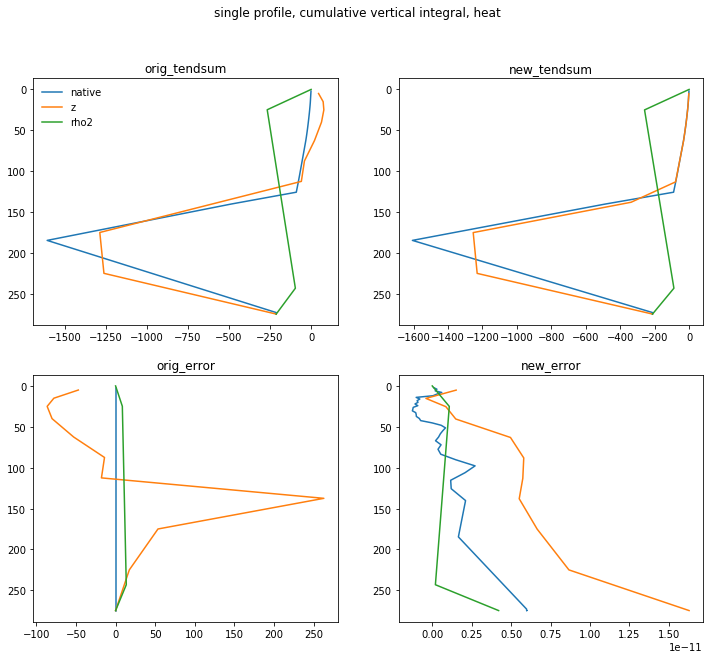

In [8]:
v = 'heat'
draw_profile(prof,v=v,title='single profile, cumulative vertical integral, '+v)

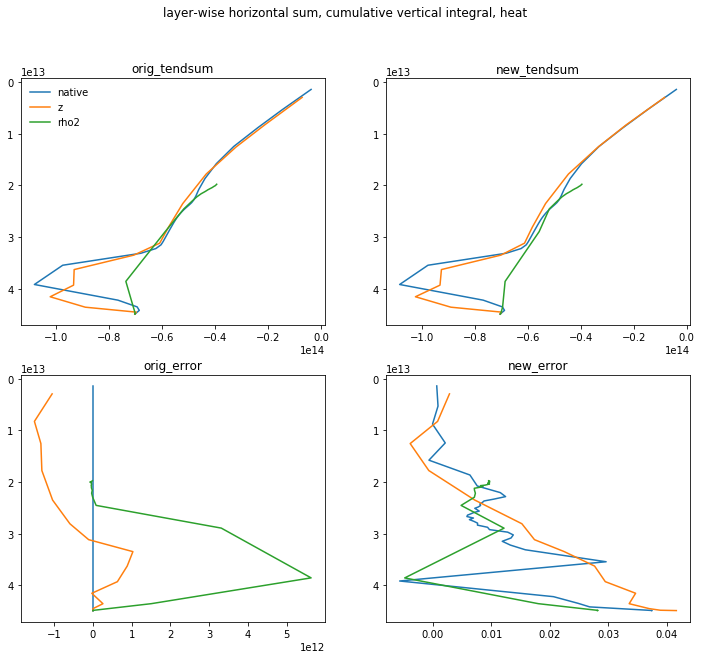

In [23]:
draw_profile(hvsum,v='heat',title='layer-wise horizontal sum, cumulative vertical integral, heat')

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


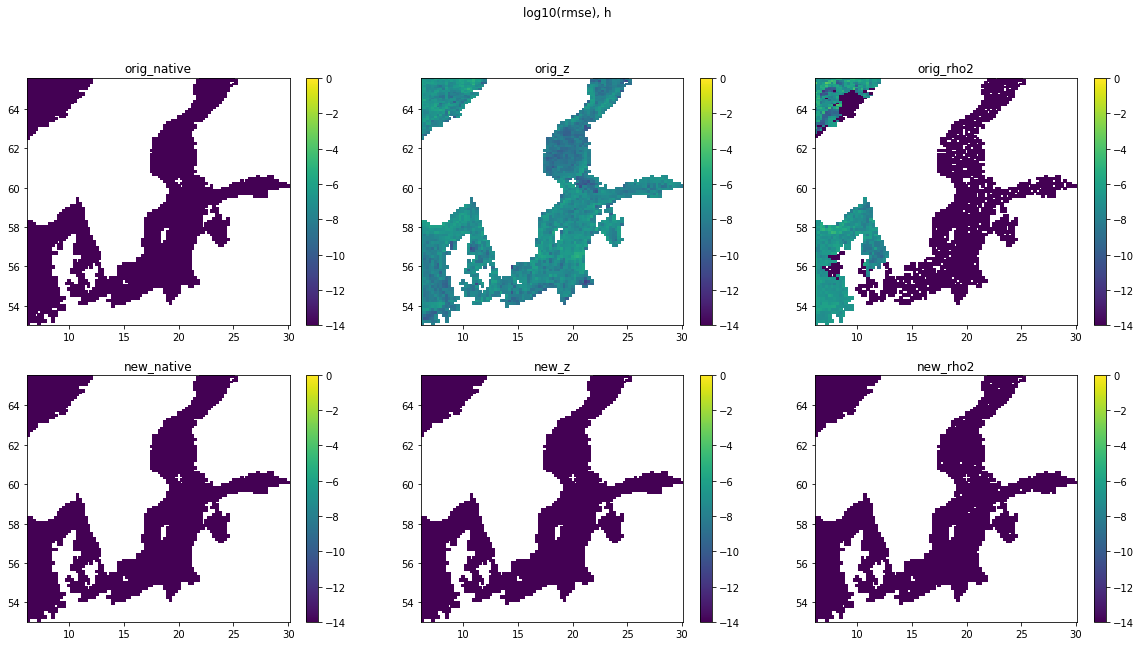

In [14]:
ax = {}
fig, ((ax['orig_native'],ax['orig_z'],ax['orig_rho2']),
      (ax['new_native'],ax['new_z'],ax['new_rho2'])) = plt.subplots(figsize = (20,10), ncols = 3, nrows = 2)
v = 'h'
fig.suptitle('log10(rmse), '+v)
for e in exps:
    for g in grids:
        axname = e+'_'+g
        im = ax[axname].pcolormesh(rmse[axname+'_'+v]['xh'],rmse[axname+'_'+v]['yh'],np.log10(rmse[axname+'_'+v]))
        ax[axname].set_title(axname)
        plt.colorbar(im,ax=ax[axname])
        im.set_clim([-14,0])

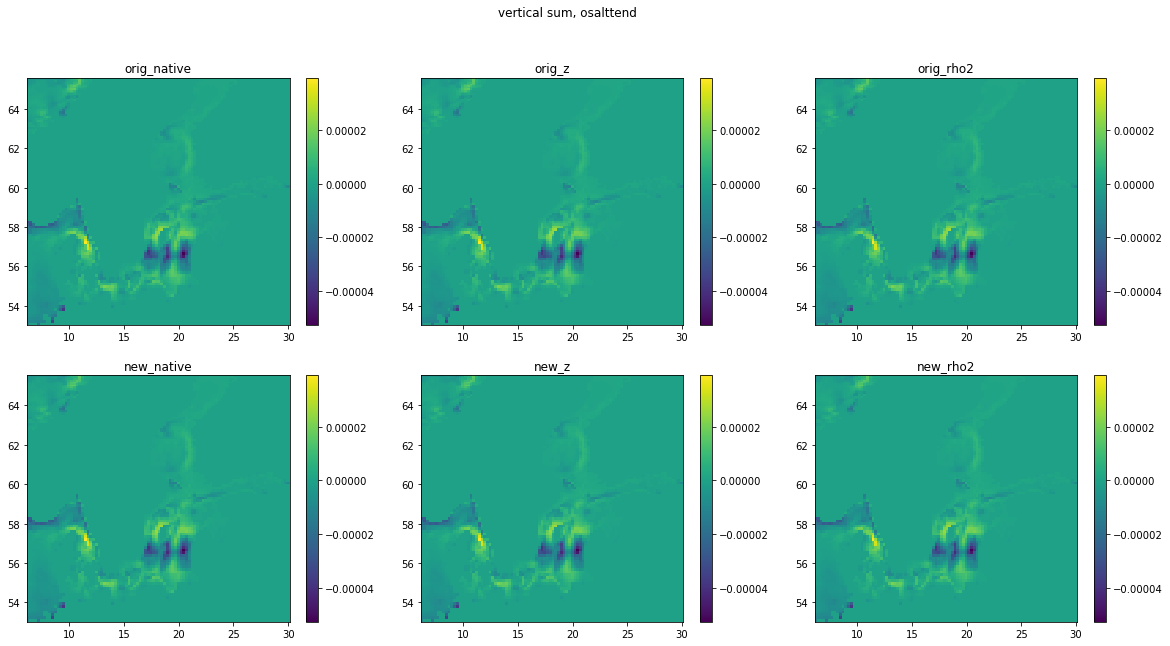

In [22]:
ax = {}
fig, ((ax['orig_native'],ax['orig_z'],ax['orig_rho2']),
      (ax['new_native'],ax['new_z'],ax['new_rho2'])) = plt.subplots(figsize = (20,10), ncols = 3, nrows = 2)
v = 'osalttend'
fig.suptitle('vertical sum, '+v)
for e in exps:
    for g in grids:
        axname = e+'_'+g
        im = ax[axname].pcolormesh(vsum[axname]['xh'],vsum[axname]['yh'],vsum[axname][v].isel({vertc[g]:-1}))
        ax[axname].set_title(axname)
        plt.colorbar(im,ax=ax[axname])

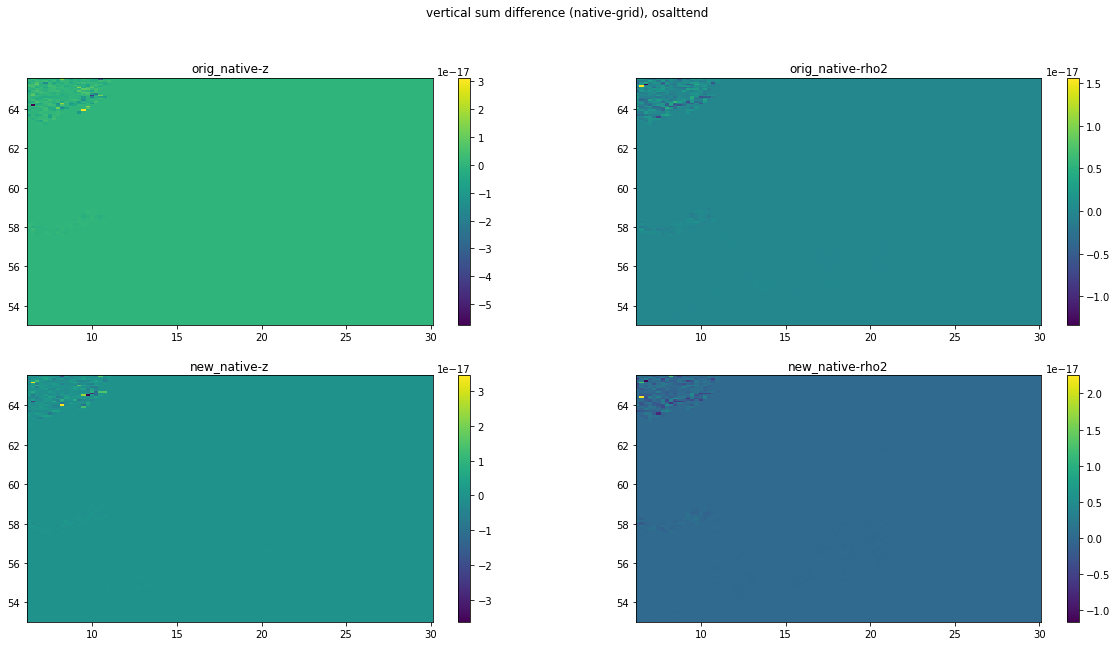

In [21]:
ax = {}
fig, ((ax['orig_native-z'],ax['orig_native-rho2']),
      (ax['new_native-z'],ax['new_native-rho2'])) = plt.subplots(figsize = (20,10), ncols = 2, nrows = 2)
v = 'osalttend'
fig.suptitle('vertical sum difference (native-grid), '+v)
for e in exps:
    for g in grids[1:]:
        ename = e+'_'+g
        axname = e+'_native-'+g
        im = ax[axname].pcolormesh(vsum[ename]['xh'],vsum[ename]['yh'],
                                   (vsum[e+'_native'][v].isel({'zl':-1})-vsum[ename][v]).isel({vertc[g]:-1}))
        ax[axname].set_title(axname)
        plt.colorbar(im,ax=ax[axname])